# Plot Galactic globular Cluster

In [1]:
!ls ../fitting/output_examples

ggc_id1_23Jun08-20.08_mcmc.h5
mock_parametric_phot_23May29-09.04_result.h5
mock_parametric_spec_23May29-12.28_result.h5
mock_parametric_specphot_23May29-18.30_result.h5


In [2]:

"""show_gnz11.py - show a photometric redshift fit to GNz-11
"""

from argparse import ArgumentParser
import numpy as np

import matplotlib.pyplot as pl
from matplotlib import rcParams, gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker

from prospect.plotting import FigureMaker, chain_to_struct, dict_to_struct
from prospect.plotting.utils import boxplot, get_simple_prior
from prospect.plotting.corner import allcorner, marginal, quantile, _quantile
from prospect.plotting.sed import to_nufnu, convolve_spec
from prospect.plotting.sfh import ratios_to_sfrs, sfh_quantiles

try:
    from exspect.examples.photoz import zred_to_agebins, zlogsfr_ratios_to_masses
except(ImportError):
    pass
from defaults import pretty, plot_defaults, colorcycle


rcParams = plot_defaults(rcParams)

In [3]:
class Plotter(FigureMaker):

    show = ["logzsol", "dust2", "logmass", "gas_logu", "dust_index", "igm_factor"]
    phot_samples = None

    #def build_sps(self):
    #    print("building sps")
    #    self.sps = build_sps(**self.result["run_params"])

    def plot_all(self):
        self.make_axes()
        self.styles()
        self.kkwargs = dict(color=colorcycle[1], linewidth=0.75)
        self.art["spec_post"] = Line2D([], [], **self.kkwargs)

        self.plot_zred(self.zax)
        self.plot_posteriors(self.paxes)
        self.plot_sfh(self.hax, nt=100)
        if self.n_seds >= 0:
            self.make_seds()
        self.plot_sed(self.sax, self.rax)

    def make_axes(self):
        self.fig = pl.figure(figsize=(10.0, 9.5))
        gs = gridspec.GridSpec(8, 6, width_ratios=6 * [10],
                               height_ratios=[4, 1, 1.25, 3, 1.25, 2.5, 1.25, 2.5],
                               wspace=0.15, hspace=0.03,
                               left=0.1, right=0.98, top=0.95, bottom=0.1)
        self.sax = self.fig.add_subplot(gs[0, :])
        self.rax = self.fig.add_subplot(gs[1, :], sharex=self.sax)
        self.zax = self.fig.add_subplot(gs[3, :])
        self.paxes = [self.fig.add_subplot(gs[5+2*j, 3+i]) for i in range(3) for j in range(2)]
        self.hax = self.fig.add_subplot(gs[5:8, 0:3])

    def plot_sed(self, sax, rax):
        """ --- plot SED and SED posteriors ---
        """
        zbest = self.chain["zred"][self.ind_best][0]

        # --- photometric data ---
        owave, ophot, ounc = self.obs["phot_wave"], self.obs["maggies"], self.obs["maggies_unc"]
        phot_width = np.array([f.effective_width for f in self.obs["filters"]])
        maxw, minw = np.max(owave + phot_width) * 1.02, 900.0
        phot_width /= 1e4
        if self.nufnu:
            _, ophot = to_nufnu(owave, ophot)
            owave, ounc = to_nufnu(owave, ounc)
        else:
            owave = owave.copy() / 1e4

        # --- posterior samples ---
        if self.n_seds > 0:
            self.spec_wave = self.sps.wavelengths * (1 + zbest)
            ckw = dict(minw=minw, maxw=maxw, R=500*2.35, nufnu=self.nufnu)
            if self.nufnu:
                swave, spec_best = convolve_spec(self.spec_wave, [self.spec_best], **ckw)
                spec_best = np.squeeze(spec_best)
                pwave, phot_best = to_nufnu(self.obs["phot_wave"], self.phot_best)
                pwave, phot = to_nufnu(self.obs["phot_wave"], self.phot_samples)
            else:
                swave, spec_best = self.spec_wave / 1e4, self.spec_best
                phot, phot_best = self.phot_samples, self.phot_best

            self.bkwargs = dict(alpha=0.8,
                                facecolor=self.pkwargs["color"], edgecolor="k")
            self.art["sed_post"] = Patch(**self.bkwargs)
            widths = 0.1 * owave  # phot_width
            boxplot(phot.T, owave, widths, ax=sax, **self.bkwargs)
            sax.plot(swave, spec_best, **self.kkwargs)

            # --- plot_residuals
            if rax is not None:
                chi = (ophot - phot_best) / ounc
                rax.plot(owave, chi, **self.dkwargs)  #marker="o", linestyle="", color="black")
                rax.axhline(0, linestyle=":", color="black")

        # --- plot data ---
        print(owave, ophot)
        sax.errorbar(owave, ophot, ounc, linestyle="", color="black",)
        sax.plot(owave, ophot, **self.dkwargs)

        # --- prettify ---
        sax.set_xscale("log")
        sax.set_yscale("log")
        if not self.nufnu:
            sax.set_ylim(1.1e-13, 5e-10)
            sax.set_ylabel(r"$f_\nu$ (maggies)")
        artists = [self.art["phot_data"], self.art["spec_post"]]
        legends = [r"Data (O16)", r"MAP spectrum ($z=${:3.2f})".format(zbest)]
        if "sed_post" in self.art:
            artists += [self.art["sed_post"]]
            legends += [r"Posterior SED"]

        sax.legend(artists, legends, loc="upper left", fontsize=10)
        sax.set_xticklabels([])
        rax.set_xticks([0.4, 1.0, 2.0, 4.0])
        rax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.1f}"))
        [ax.set_xlim(0.3, 5) for ax in [rax, sax]]

        rax.set_ylim(-2.8, 2.8)
        rax.set_ylabel(r"$\chi$")
        rax.set_xlabel(r"Observed wavelength ($\mu$m)")

    def plot_zred(self, zax):
        """--- Redshift posterior ---
        """
        z = np.squeeze(self.chain["zred"])
        marginal(z, ax=zax, weights=self.weights, histtype="stepfilled", **self.pkwargs)

        # --- annotate ---
        zp = self.model.config_dict["zred"]["prior"].params
        #zax.set_xlim(zp["mini"], zp["maxi"])
        q = _quantile(z, weights=self.weights, q=[0.16, 0.50, 0.84])
        zstr = r"$z_{{phot}}={{{:3.2f}}}^{{+{:3.2f}}}_{{-{:3.2f}}}$"
        zax.text(0.1, 0.8, zstr.format(q[1], q[2]-q[1], q[1]-q[0]), transform=zax.transAxes)

        # -- prettify ---
        zbest = self.chain["zred"][self.ind_best][0]
        zax.set_xlabel("Redshift")
        zax.set_ylabel("Probability")
        #zax.axvline(zbest, label=r"MAP redshift", linestyle="dashed", color=self.pkwargs["color"])
        zax.axvline(11.09, label=r"Grism redshift (O16; $z=11.09$)", **self.tkwargs)
        zax.legend(loc=(0.08, 0.2), fontsize=10)

    def plot_posteriors(self, paxes):
        """Show marginalized parameter posteriors
        """
        for i, p in enumerate(self.show):
            pax = paxes[i]
            marginal(np.squeeze(self.chain[p]), weights=self.weights, ax=pax,
                     histtype="stepfilled", **self.pkwargs)
            # --- prior ---
            xx, px = get_simple_prior(self.model.config_dict[p]["prior"], pax.get_xlim())
            pax.plot(xx, px * pax.get_ylim()[1] * 0.96, **self.rkwargs)
            pax.set_xlabel(pretty.get(p, p))
            paxes.append(pax)
        [ax.set_yticklabels("") for ax in paxes]

    def plot_sfh(self, sfhax, nt=500):
        """ Plot the SFH posterior
        """
        nbins, zmax = self.result["run_params"]["nbins_sfh"], self.result["run_params"]["zmax"]
        agebins = np.array([zred_to_agebins(s["zred"], nbins, zmax) for s in self.chain])
        sfh_samples = np.array([ratios_to_sfrs(s["logmass"], s["logsfr_ratios"], agebins=a)
                                for s, a in zip(self.chain, agebins)])
        tlook = 10**agebins / 1e9
        tvec = np.exp(np.linspace(np.log(max(tlook.min(), 0.001)), np.log(tlook.max()), nt))
        # -- shrink the bins to get a prettier SFH ---
        tlook *= np.array([1.02, 0.98])
        sq = sfh_quantiles(tvec, tlook, sfh_samples, self.weights, q=[16, 50, 84])

        # --- plot SFH ---
        sfhax.plot(tvec, sq[:, 1], '-', lw=1.5, color="k")
        sfhax.fill_between(tvec, sq[:, 0], sq[:, 2], **self.pkwargs)
        sfhax.plot(tvec, sq[:, 0], '-', lw=1.5, color="k", alpha=0.3)
        sfhax.plot(tvec, sq[:, 2], '-', lw=1.5, color="k", alpha=0.3)

        # show a few samples?  need to weight them
        #for i in range(20):
        #    t, r, s = tlook[i], sfh_samples[i], samples[i]
        #    step(*t.T, r, ax=sfhax, **hkwargs)

        # --- prettify ---
        sfhax.set_xlabel(r"Lookback Time (Gyr)")
        sfhax.set_ylabel(r"SFR (M$_\odot$/yr)")
        sfhax.set_xlim(0, 0.5)

In [4]:
parser = ArgumentParser()
parser.add_argument("--results_file", type=str, default="")
parser.add_argument("--fignum", type=str, default="")
parser.add_argument("--figext", type=str, default="png")
parser.add_argument("--prior_samples", type=int, default=1000)
parser.add_argument("--n_seds", type=int, default=0)
args = parser.parse_args(args=[])

In [5]:
# GCs
#echo "GC example"
#python gc_dash.py --n_seds=$nseds --fignum=ggc1 --results_file=$rdir/ggc1.h5

In [6]:
!ls ../fitting/output_examples/

ggc_id1_23Jun08-20.08_mcmc.h5
mock_parametric_phot_23May29-09.04_result.h5
mock_parametric_spec_23May29-12.28_result.h5
mock_parametric_specphot_23May29-18.30_result.h5


In [9]:
rdir="../fitting/output_examples"
nprior=100000
nseds=1000
ggc1 = "ggc1"
results_file = rdir + "/ggc_id1_23Jun08-20.08_mcmc.h5" 

In [11]:
parser.set_defaults(n_seds = nseds)
parser.set_defaults(fignum = ggc1)
parser.set_defaults(results_file = results_file)
args = parser.parse_args(args=[])

KeyError: 'mini'

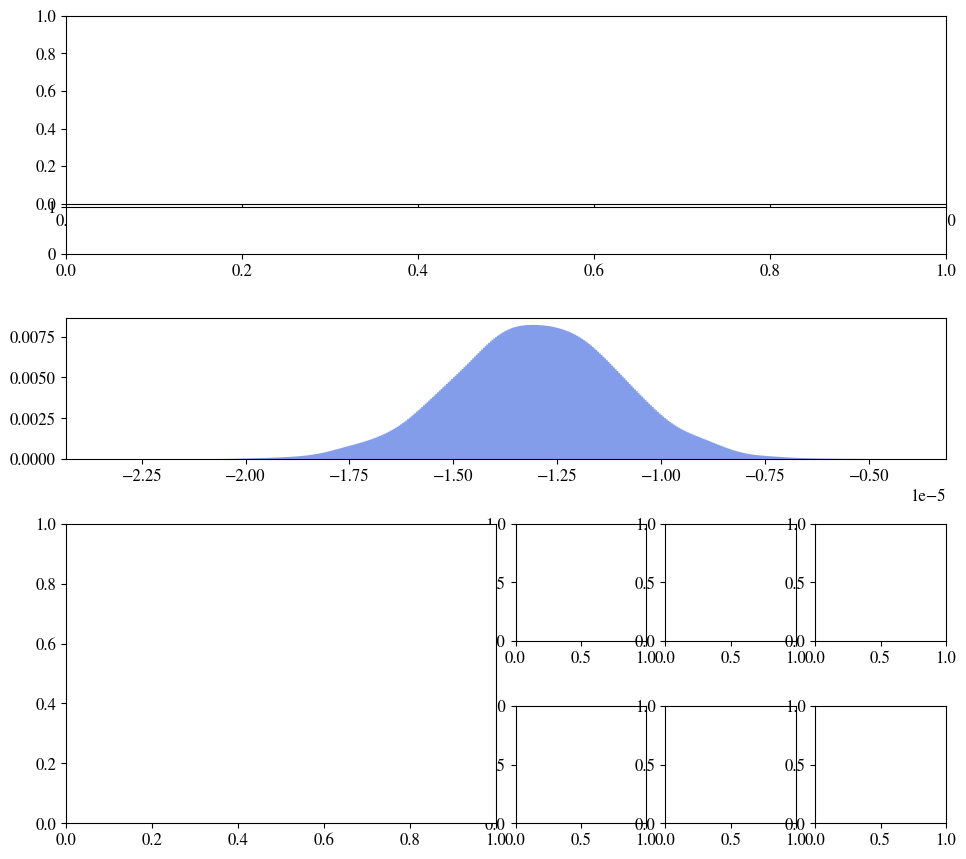

In [12]:
plotter = Plotter(nufnu=False, **vars(args))
plotter.plot_all()

 

In [ ]:

# --- Saving ---
# --------------
if args.fignum:
    plotter.fig.savefig("paperfigures/{}.{}".format(args.fignum, args.figext), dpi=400)
else:
    pl.ion()
    pl.show(